# Intraday Resistance

In [1]:
import pandas as pd
import numpy as np
import sys
import datetime 
import click
import copy
import os
from path import Path
from itertools import product

sys.path.append('../')

from technical_indicator.atr import get_atr
from kpi import get_cagr, get_volatility, get_sharpe, get_max_drawdown
from data.make_dataset import get_fx, get_stock_intraday

/anaconda3/envs/fx/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
key_path = '../key.txt'
tickers = ["MSFT","AAPL","FB","AMZN","INTC"]
#tickers = ["CSCO","VZ","IBM","QCOM","LYFT"]
data = get_stock_intraday(key = open(key_path, 'r').read(), symbols=tickers, interval='5min')

MSFT
AAPL
FB
AMZN
INTC


In [3]:
print(list(data.keys())[0])
data[tickers[0]]

MSFT


,Open,High,Low,Adj Close,Volume
date,,,,,
2020-03-31 09:35:00,158.9200,159.1900,158.3700,159.1700,4062063.0
2020-03-31 09:40:00,159.2550,159.3600,158.9869,158.9869,984960.0
2020-03-31 09:45:00,159.0960,159.3700,159.0180,159.0450,940089.0
2020-03-31 09:50:00,159.0301,159.0301,158.5400,158.5400,779766.0
2020-03-31 09:55:00,158.5000,158.5700,157.9900,158.1600,835340.0
...,...,...,...,...,...
2020-04-20 15:40:00,176.4250,176.5500,176.2200,176.2400,332986.0
2020-04-20 15:45:00,176.2600,176.4350,175.8700,176.2000,440173.0
2020-04-20 15:50:00,176.1904,176.3000,175.8100,176.1000,477006.0


In [4]:
# Calculating ATR and rolling max price for each stock
ohlc = copy.deepcopy(data)
ticker_signal = {}
ticker_return = {}

for ticker in tickers:
    print(f"Calculating ATR and rolling max for {ticker}.")
    ohlc[ticker]['ATR'] = get_atr(ohlc[ticker])
    ohlc[ticker]['roll_max_cp'] = ohlc[ticker]['High'].rolling(20).max()
    ohlc[ticker]['roll_min_cp'] = ohlc[ticker]['Low'].rolling(20).min()
    ohlc[ticker]['roll_max_vol'] = ohlc[ticker]['Volume'].rolling(20).max()
    ohlc[ticker].dropna(inplace=True)
    ticker_signal[ticker] = None
    ticker_return[ticker] = []

Calculating ATR and rolling max for MSFT.
Calculating ATR and rolling max for AAPL.
Calculating ATR and rolling max for FB.
Calculating ATR and rolling max for AMZN.
Calculating ATR and rolling max for INTC.


In [5]:
def buy_signal(df, i):
    return df['High'][i] >= df['roll_max_cp'][i] and \
        df['Volume'][i] > 1.5*df['roll_max_vol'][i-1]

def sell_signal(df, i):
    return df['Low'][i] <= df['roll_min_cp'][i] and \
                 df['Volume'][i] < 1.5*df['roll_max_vol'][i-1]

for ticker in tickers:
    print(f"Calculating returns for {ticker}")
    try:
        del df
    except NameError:
        pass
    finally:
        df = ohlc[ticker].reset_index()
        
    for i, _ in df.iterrows():
        # No signal yet
        if i == 0:
            ticker_return[ticker].append(0)
        elif ticker_signal[ticker] is None:
            ticker_return[ticker].append(0)
            if buy_signal(df, i):
                ticker_signal[ticker] = 'Buy'
            elif sell_signal(df, i):
                ticker_signal[ticker] = 'Sell'
                
        elif ticker_signal[ticker] == 'Buy':
            stoploss_return = ((df['Adj Close'][i-1] - df['ATR'][i-1])/ df['Adj Close'][i-1]) - 1
            if df['Adj Close'][i] < df['Adj Close'][i-1] - df['ATR'][i-1]:
                ticker_signal[ticker] = None
                ticker_return[ticker].append(stoploss_return)
            elif sell_signal(df, i):
                ticker_signal[ticker] = 'Sell'
                ticker_return[ticker].append(stoploss_return)
            else:
                ticker_return[ticker].append((df['Adj Close'][i] / df['Adj Close'][i-1]) - 1)
                
        elif ticker_signal[ticker] == 'Sell':
            stoploss_return = (df['Adj Close'][i-1] / (df['Adj Close'][i-1] + df['ATR'][i-1])) - 1
            if df['Adj Close'][i] > df['Adj Close'][i-1] + df['ATR'][i-1]:
                ticker_signal[ticker] = None
                ticker_return[ticker].append(stoploss_return)
            elif buy_signal(df, i):
                ticker_signal[ticker] = 'Buy'
                ticker_return[ticker].append(stoploss_return)
            else:
                ticker_return[ticker].append((df['Adj Close'][i-1] / df['Adj Close'][i]) - 1)
    
    ohlc[ticker]['return'] = ticker_return[ticker]
    

Calculating returns for MSFT
Calculating returns for AAPL
Calculating returns for FB
Calculating returns for AMZN
Calculating returns for INTC


In [6]:
backtest_stats = pd.DataFrame()
for ticker in tickers:
    backtest_stats[ticker] = ohlc[ticker]['return']
backtest_stats['return'] = backtest_stats.mean(axis=1)

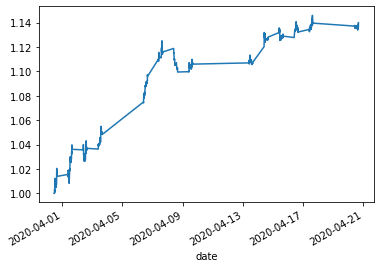

In [7]:
(1 + backtest_stats['return']).cumprod().plot()

In [8]:
(1 + backtest_stats['return']).cumprod()

date
2020-03-31 11:15:00    1.000000
2020-03-31 11:20:00    1.000000
2020-03-31 11:25:00    1.000000
2020-03-31 11:30:00    1.000000
2020-03-31 11:35:00    1.000000
                         ...   
2020-04-20 15:40:00    1.137265
2020-04-20 15:45:00    1.137224
2020-04-20 15:50:00    1.136405
2020-04-20 15:55:00    1.138371
2020-04-20 16:00:00    1.140100
Name: return, Length: 1072, dtype: float64

In [9]:
get_cagr(backtest_stats)

,MSFT,AAPL,FB,AMZN,INTC,return
date,,,,,,
2020-04-20 15:40:00,0.0,0.002950,0.000000,0.002850,0.001937,0.001547
2020-04-20 15:45:00,0.0,0.000550,0.000000,0.000448,-0.001178,-0.000036
2020-04-20 15:50:00,0.0,-0.002058,0.000000,-0.000619,-0.000925,-0.000720
2020-04-20 15:55:00,0.0,0.002809,0.000000,0.001621,0.004221,0.001730
2020-04-20 16:00:00,0.0,0.002872,0.001206,0.002500,0.001014,0.001518
